# Labelisation: Finding the rotation

## Intro

The goal of this notebook is to find the transformation from the coordinates of the microscope to the coordinates of the final stiched image in Prince.\
WARNING: x and y in Loreto's set up are inversed from x and y in Experiment object\
WARNING: coordinates from the microscope are in micrometers

## Set up

In [68]:
from amftrack.util.sys import storage_path, get_current_folders_local, update_plate_info_local
from amftrack.util.file import chose_file
from amftrack.util.plot import show_image
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment
from amftrack.pipeline.functions.image_processing.experiment_util import plot_full_image_with_features, get_all_edges
from amftrack.util.image_analysis import find_transformation, get_transformation
import os
import matplotlib.pyplot as plt
import logging
#%matplotlib notebook

In [2]:
import logging
import os
logger = logging.getLogger("PIL.TiffImagePlugin")
logger.setLevel("INFO")

logger = logging.getLogger("urllib3")
logger.setLevel("INFO")

Loading the experiment object:

In [3]:
directory = os.path.join(storage_path, "width1", "full_plates") + "/"
plate_name = "20220325_1423_Plate907"
update_plate_info_local(directory)
folder_df = get_current_folders_local(directory)

In [4]:
selected_df = folder_df.loc[folder_df['folder']==plate_name]

In [5]:
selected_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
1,/media/kahane/AMFtopology02/storage/width1/ful...,907,9,'Carrot','A5','001P100N100C','Y','-',20220321,25,...,True,True,False,False,True,True,False,False,"25.03.2022, 14:23:",20220325_1423_Plate907


In [6]:
i = 0

In [7]:
plate = int(list(selected_df['folder'])[i].split('_')[-1][5:])
folder_list = list(selected_df['folder'])
directory_name = folder_list[i]

In [8]:
exp = Experiment(plate, directory)
exp.load(selected_df.loc[selected_df['folder']==directory_name],labeled=False)
exp.load_tile_information(0)

2022-03-25 14:23:00


In [9]:
len(exp.nx_graph[0])

2407

## 0/ Parameters

In [103]:
DOWNSIZING = 5
micro_factor = 1.725

## 1/ Close up image

In [104]:
image_name = "20220324_Plate907_046"

In [105]:
image_path = chose_file(os.path.join(storage_path, "width1/groundtruth", image_name))

Text(0.5, 1.0, '20220324_Plate907_046')

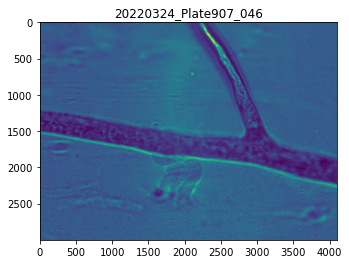

In [12]:
show_image(image_path)
plt.title(image_name)

Coordinates of the image (MICROSCOPE REF) (x grand, y petit)

(x grand, y petit)

In [106]:
coord_of_image_um = [51620, 55480]

## 2/ Snapshot

Text(0.5, 1.0, '046_Image__2022-03-24__12-51-26.tiff')

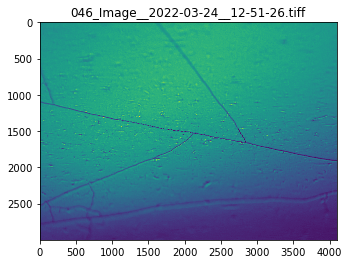

In [15]:
snapshot_name = "046_Image__2022-03-24__12-51-26.tiff"
snapshot_path = os.path.join(storage_path, "width1/snapshot/20220324_Plate907_Snapshots", snapshot_name)
show_image(snapshot_path)
plt.title(snapshot_name)

## 3/ Fullsize image

<IPython.core.display.Javascript object>


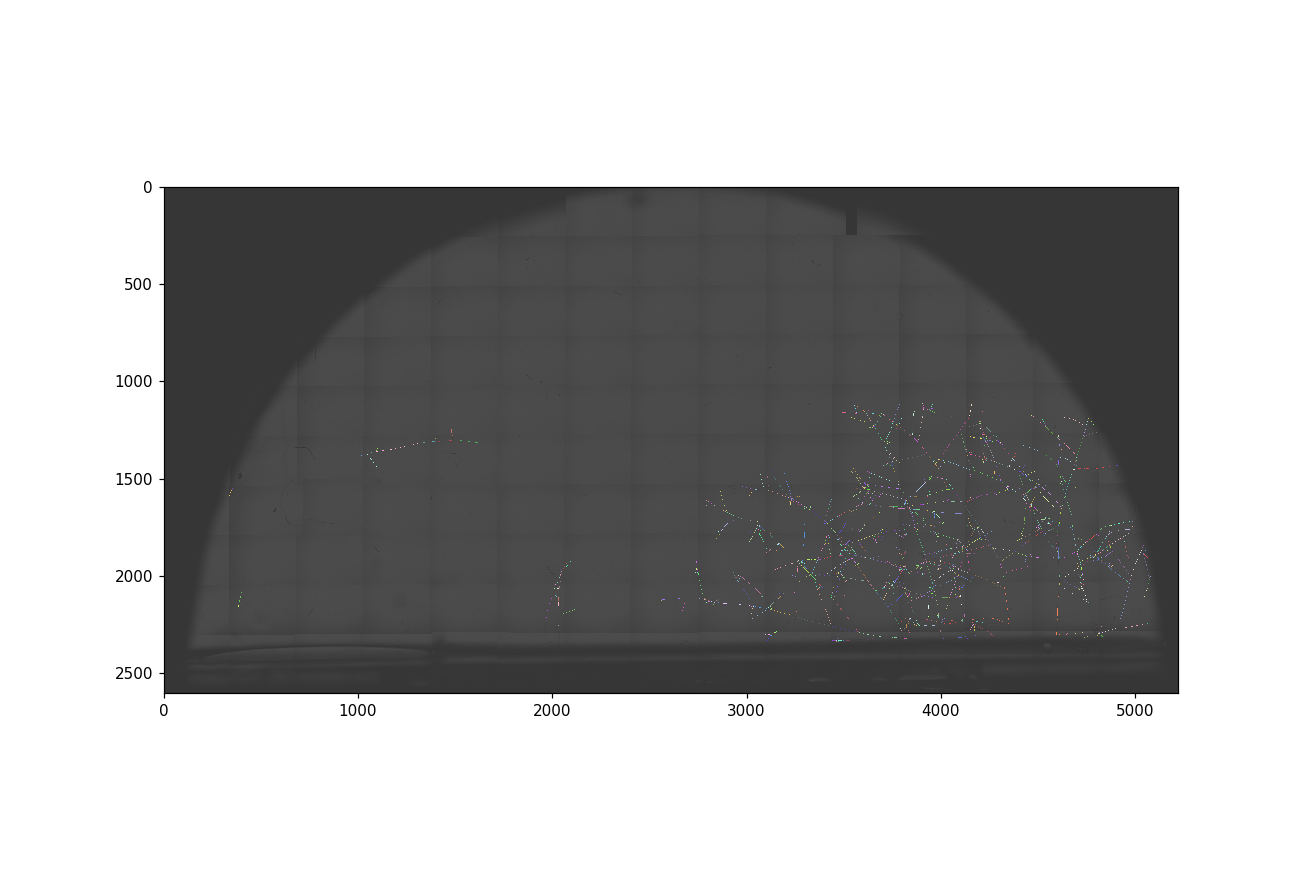

In [20]:
%matplotlib notebook
plot_full_image_with_features(exp, 0, downsizing = DOWNSIZING, edges = get_all_edges(exp, 0))

Coordinates in the full size COMPRESSED image (x small, y big)

In [107]:
coord_in_prince_compressed = [4574, 7130]

## 4/ Computation

For image coordinates: INVERSION x and y + conversion to pixel + conversion to int

In [108]:
coord_of_image_pix = [int(coord_of_image_um[1]/micro_factor), int(coord_of_image_um[0]/micro_factor)]

For coordinates in the Prince full size image: decompression (*downsize factor)

In [109]:
coord_in_prince_pix = [coord_in_prince_compressed[0]*DOWNSIZING, coord_in_prince_compressed[1]*DOWNSIZING]

## 5/ Display

In [110]:
def affichage():
    print(f"""
    POINT \n
    image: {image_name}
    snapshot: {snapshot_name}
    coord_image: (wrong (x, y)) (um) {coord_of_image_um}
    coord_image (right (x, y)): (pix) {coord_of_image_pix}
    prince (compressed in pixels): {coord_in_prince_compressed}
    prince (pixel): {coord_in_prince_pix}\n""")

In [111]:
affichage()


    POINT 

    image: 20220324_Plate907_046
    snapshot: 046_Image__2022-03-24__12-51-26.tiff
    coord_image: (wrong (x, y)) (um) [51620, 55480]
    coord_image (right (x, y)): (pix) [32162, 29924]
    prince (compressed in pixels): [4574, 7130]
    prince (pixel): [22870, 35650]



### Historic of points

## 6/ Finding the rotation and the translation

Coordinates from the microscope INVERSED + CONVERTED TO INT + CONVERTED TO PIXELS (coord_image:(pix))

In [114]:
old_coord_pix = [[26597.10144927536, 39895.65217391304],
 [23814.492753623188, 31652.173913043476],
 [23026.086956521736, 31431.884057971012],
 [32162.31884057971, 29924.63768115942]]

Coordinates from the prince image DECOMPRESSED (coord_in_prince_pix)

In [115]:
new_coord_pix = [[16500, 46175], [14140, 37420], [13280, 37060], [22870, 35650]]

In [117]:
R, t = find_transformation(old_coord_pix, new_coord_pix)

In [118]:
f = get_transformation(R, t)

In [120]:
f([32162.31884057971, 29924.63768115942])

array([22575.1625255 , 35984.81522394])

## RESULT

In [121]:
R

array([[ 0.99934915, -0.03607328],
       [ 0.03607328,  0.99934915]])

In [123]:
t

array([-8486.74354496,  4919.45372883])

## HISTORY

R = 
array([[ 0.99934915,  0.03607328],
       [-0.03607328,  0.99934915]])

t = 
array([ 4919.45372883, -8486.74354496])

# Brouillon

## Displaying the full image (old method)

## Brouillon

In [2]:
import numpy as np

In [3]:
a = [[26597.10144927536, 39895.65217391304],
 [23814.492753623188, 31652.173913043476],
 [23026.086956521736, 31431.884057971012],
 [32162.31884057971, 29924.63768115942]]

In [4]:
b = [[16500, 46175], [14140, 37420], [13280, 37060], [22870, 35650]]

In [6]:
for i in range(4):
    for j in range(i):
        dx = np.linalg.norm(np.array(a[i])-np.array(a[j]))
        dfx = np.linalg.norm(np.array(b[i])-np.array(b[j]))
        print(dfx/dx)

1.0421878069886255
1.052335761118059
1.138902067236802
1.0773779228607985
1.044919064689274
1.046802107411834
